In [1]:
import os
import numpy as np
import nibabel as nib
from nibabel.processing import resample_to_output
from skimage.transform import resize
from skimage.restoration import denoise_nl_means, estimate_sigma
from nilearn.masking import compute_brain_mask
from scipy.ndimage import zoom
import glob

In [2]:
INPUT_MODALITY = 't1c'
TARGET_MODALITY = 't2w'
NEW_SHAPE = (128, 160, 128)  # ajustar se quiser preservar resolução original
VOXEL_SIZE = (1.0, 1.0, 1.0)  # mm³ padrão BraTS
DATASET_DIR = '}datasets/brats/training_data'  # pasta onde estão as subpastas dos pacientes
SAVE_PATH = 'dataset_t1c_to_t2w.npz'

In [3]:
import torch

# Verifica se há GPU disponível
print("GPU disponível:", torch.cuda.is_available())

# Nome da GPU
if torch.cuda.is_available():
    print("Nome da GPU:", torch.cuda.get_device_name(0))
    
# Dispositivo padrão
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo usado:", device)

GPU disponível: True
Nome da GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Dispositivo usado: cuda


In [4]:
torch.cuda.empty_cache()

# Load and Pre-Process

## Load function

In [5]:
def load_nifti(path):

    """Carrega e reorienta uma imagem NIfTI para o espaço canônico (RAS+).
    Garante que todas as imagens tenham a mesma orientação espacial (alinhadas em relação aos mesmos eixos do cérebro)"""

    img = nib.load(path)
    img = nib.as_closest_canonical(img) #RAS = right, anterior, superior
    return img

## Pre-processing functions

In [6]:
def resample_image(img, voxel_size=VOXEL_SIZE):
    """Padroniza o tamanho dos voxels em 1mm³. Isso garante que todas as imagens fiquem no mesmo espaço e escala, 
    o que é essencial para comparações, registros e aprendizado de máquina."""
    return resample_to_output(img, voxel_sizes=voxel_size)


def nlmeans_and_normalize(data, patch_size=3, patch_distance=5, h_factor=1.0):
    """
    Aplica denoising Non-Local Means (NLM) e normaliza a imagem.
    
    Parâmetros:
        data: array numpy (3D MRI)
        patch_size: tamanho do patch para comparar similaridades (ex: 3x3x3)
        patch_distance: distância máxima para busca de patches similares
        h_factor: fator de suavização (controla o peso do filtro)
    """
    
    # Estima o nível de ruído na imagem
    sigma_est = np.mean(estimate_sigma(data, channel_axis=None))
    
    # Aplica Non-Local Means (NLM)
    denoised = denoise_nl_means(
        data,
        h=h_factor * sigma_est,       # controla o quanto suaviza
        patch_size=patch_size,
        patch_distance=patch_distance,
        channel_axis=None,            # MRI não tem canais RGB
        fast_mode=True
    )
    
    # Normaliza a intensidade com z-score
    normed = (denoised - np.mean(denoised)) / (np.std(denoised) + 1e-8)
    return normed


def skull_strip(data):
    """
    Gera uma máscara do cérebro usando nilearn.
    Retorna a máscara binária (True = cérebro) e a imagem mascarada.
    """
    temp_img = nib.Nifti1Image(data, affine=np.eye(4)) # objeto Nifti1Image temporário, necessário para nilearn
    
    # Calcula e aplica máscara do cérebro
    brain_mask = compute_brain_mask(temp_img).get_fdata().astype(bool)
    masked_data = np.where(brain_mask, data, 0)

    return masked_data, brain_mask

def crop_background_with_padding(data, pad=5):
    """
    Recorta a imagem baseado na máscara do cérebro, mas adiciona padding seguro.
    Retorna o volume recortado, máscara recortada e coordenadas.
    
    pad: número de voxels extras a adicionar em cada direção
    """ 
    masked_data, brain_mask = skull_strip(data)
    coords = np.array(np.nonzero(brain_mask))
    if coords.size == 0:
        return masked_data, None, None  # máscara vazia
    minz, miny, minx = coords.min(axis=1)
    maxz, maxy, maxx = coords.max(axis=1)
    
    # Aplicar padding
    minz, miny, minx = max(minz - pad, 0), max(miny - pad, 0), max(minx - pad, 0)
    maxz, maxy, maxx = min(maxz + pad, data.shape[0]), min(maxy + pad, data.shape[1]), min(maxx + pad, data.shape[2])
    
    cropped = masked_data[minz:maxz, miny:maxy, minx:maxx]
    cropped_mask = brain_mask[minz:maxz, miny:maxy, minx:maxx]
    
    return cropped, cropped_mask, (minz, maxz, miny, maxy, minx, maxx)


def crop_background_with_mask(data):
    """
    Recorta a imagem baseado na máscara do cérebro.
    Retorna o volume recortado e as coordenadas para reconstrução.
    """
    masked_data, brain_mask = skull_strip(data)
    coords = np.array(np.nonzero(brain_mask))
    if coords.size == 0:
        return masked_data, None  # máscara vazia
    
    minz, miny, minx = coords.min(axis=1)
    maxz, maxy, maxx = coords.max(axis=1)
    
    cropped = masked_data[minz:maxz, miny:maxy, minx:maxx]
    cropped_mask = brain_mask[minz:maxz, miny:maxy, minx:maxx]
    
    return cropped, cropped_mask, (minz, maxz, miny, maxy, minx, maxx)

def resize_volume(img, new_shape=NEW_SHAPE):
    """Redimensiona o volume 3D para new_shape sem cortar,
    ajustando proporcionalmente cada eixo via interpolação linear."""
    factors = [n / s for n, s in zip(new_shape, img.shape)]
    return zoom(img, factors, order=3)

In [7]:
def preprocess_patient(patient_dir):
    """
    Carrega t1c (entrada) e t2w (alvo) de um paciente,
    aplica o pipeline completo e retorna volumes prontos.
    """
    pid = os.path.basename(patient_dir)
    t1c_path = os.path.join(patient_dir, f"{pid}-{INPUT_MODALITY}.nii.gz")
    t2w_path = os.path.join(patient_dir, f"{pid}-{TARGET_MODALITY}.nii.gz")

    # Load + Reorient
    img_in = load_nifti(t1c_path)
    img_out = load_nifti(t2w_path)

    # Resample para voxel uniforme
    img_in = resample_image(img_in)
    img_out = resample_image(img_out)

    data_in = img_in.get_fdata()
    data_out = img_out.get_fdata()

    # Background removing (com coordenadas iguais)
    cropped_in, _, bbox = crop_background_with_mask(data_in)
    if bbox is None:
        return None, None
    minz, maxz, miny, maxy, minx, maxx = bbox
    masked_data_out, _ = skull_strip(data_out)
    cropped_out = masked_data_out[minz:maxz, miny:maxy, minx:maxx]

    # NLM + Normalização
    cropped_in = nlmeans_and_normalize(data_in)
    cropped_out = nlmeans_and_normalize(data_out)

    # Resize para shape fixo
    cropped_in = resize_volume(cropped_in)
    cropped_out = resize_volume(cropped_out)

    return cropped_in, cropped_out

## Process Patients

In [8]:
X_list, Y_list = [], []

patient_dirs = sorted(glob.glob(os.path.join("datasets/brats/training_data/BraTS-GLI-00*-100")))
print(f"Encontrados {len(patient_dirs)} pacientes.") 

Encontrados 38 pacientes.


## Visualizar antes e depois do pré-processamento

Visualizando paciente: BraTS-GLI-00005-100


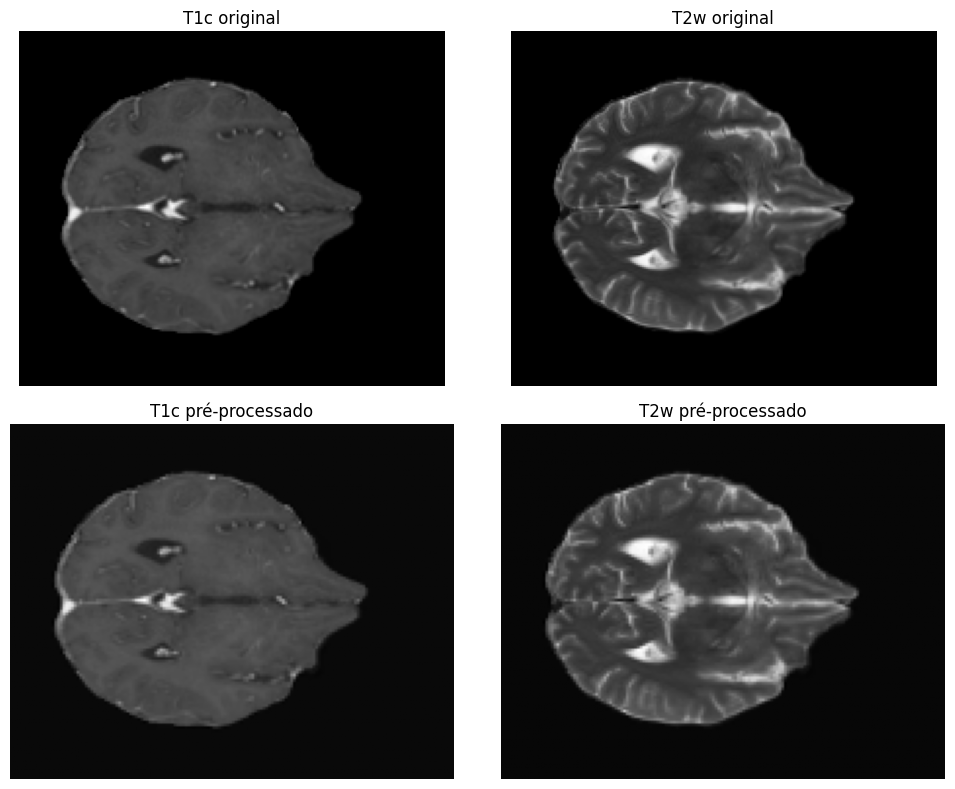

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Escolher o índice do paciente que você quer visualizar
idx = 0
patient_dir = patient_dirs[idx]
pid = os.path.basename(patient_dir)
print(f"Visualizando paciente: {pid}")

# 1. Carregar originais (antes do pré-processamento)
t1c_path = os.path.join(patient_dir, f"{pid}-{INPUT_MODALITY}.nii.gz")
t2w_path = os.path.join(patient_dir, f"{pid}-{TARGET_MODALITY}.nii.gz")

img_in = load_nifti(t1c_path)
img_out = load_nifti(t2w_path)

orig_t1c = img_in.get_fdata()
orig_t2w = img_out.get_fdata()

# 2. Aplicar o pré-processamento
proc_X, proc_Y = preprocess_patient(patient_dir)

# 3. Escolher fatia central (por exemplo no eixo z)
orig_shape = orig_t1c.shape
proc_shape = proc_X.shape

slice_orig = orig_shape[2] // 2
slice_proc = proc_shape[2] // 2

# 4. Visualizar
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Antes (T1c e T2w)
axes[0, 0].imshow(orig_t1c[:, :, slice_orig], cmap='gray')
axes[0, 0].set_title("T1c original")
axes[0, 1].imshow(orig_t2w[:, :, slice_orig], cmap='gray')
axes[0, 1].set_title("T2w original")

# Depois (pré-processadas)
axes[1, 0].imshow(proc_X[:, :, slice_proc], cmap='gray')
axes[1, 0].set_title("T1c pré-processado")
axes[1, 1].imshow(proc_Y[:, :, slice_proc], cmap='gray')
axes[1, 1].set_title("T2w pré-processado")

# Remover coordenadas e ajustar layout
for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()


## Pré-processar todos os pacientes

In [10]:
for i, p_dir in enumerate(patient_dirs):
    print(f"[{i+1}/{len(patient_dirs)}] Processando {p_dir}...")
    X, Y = preprocess_patient(p_dir)
    if X is not None:
        X_list.append(X)
        Y_list.append(Y)

[1/38] Processando datasets/brats/training_data\BraTS-GLI-00005-100...
[2/38] Processando datasets/brats/training_data\BraTS-GLI-00006-100...
[3/38] Processando datasets/brats/training_data\BraTS-GLI-00008-100...
[4/38] Processando datasets/brats/training_data\BraTS-GLI-00009-100...
[5/38] Processando datasets/brats/training_data\BraTS-GLI-00020-100...
[6/38] Processando datasets/brats/training_data\BraTS-GLI-00027-100...
[7/38] Processando datasets/brats/training_data\BraTS-GLI-00033-100...
[8/38] Processando datasets/brats/training_data\BraTS-GLI-00046-100...
[9/38] Processando datasets/brats/training_data\BraTS-GLI-00060-100...
[10/38] Processando datasets/brats/training_data\BraTS-GLI-00063-100...
[11/38] Processando datasets/brats/training_data\BraTS-GLI-00078-100...
[12/38] Processando datasets/brats/training_data\BraTS-GLI-00080-100...
[13/38] Processando datasets/brats/training_data\BraTS-GLI-00085-100...
[14/38] Processando datasets/brats/training_data\BraTS-GLI-00096-100...
[

In [11]:
X_list = [x.astype(np.float32) for x in X_list]
Y_list = [y.astype(np.float32) for y in Y_list]

In [12]:
X_all = np.stack(X_list, axis=0)
Y_all = np.stack(Y_list, axis=0)

In [13]:
print("Shape final:")
print("X:", X_all.shape, "Y:", Y_all.shape)

Shape final:
X: (38, 128, 160, 128) Y: (38, 128, 160, 128)


In [14]:
# Converter para arrays numpy
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print("Shape após augmentation:")
print("X:", X_all.shape)
print("Y:", Y_all.shape)

# Salvar dataset aumentado
np.savez_compressed(SAVE_PATH, X=X_all, Y=Y_all)
print(f"Dataset salvo em {SAVE_PATH}")

Shape após augmentation:
X: (38, 128, 160, 128)
Y: (38, 128, 160, 128)
Dataset salvo em dataset_t1c_to_t2w.npz


# Data Augmentation

In [15]:
def pad_or_crop(volume, target_shape=NEW_SHAPE):
    """Centraliza o volume e faz pad/crop para atingir o tamanho alvo."""
    result = np.zeros(target_shape, dtype=volume.dtype)
    in_shape = volume.shape
    min_shape = tuple(min(i, t) for i, t in zip(in_shape, target_shape))

    # Cálculo dos índices de origem e destino (para centralizar)
    start_src = [(i - m) // 2 for i, m in zip(in_shape, min_shape)]
    start_dst = [(t - m) // 2 for t, m in zip(target_shape, min_shape)]

    slices_src = tuple(slice(s, s + m) for s, m in zip(start_src, min_shape))
    slices_dst = tuple(slice(s, s + m) for s, m in zip(start_dst, min_shape))

    result[slices_dst] = volume[slices_src]
    return result

In [16]:
from scipy.ndimage import rotate, zoom, gaussian_filter
import random

def random_rotation(volume, angle_range=(15,20)):
    """Aplica rotação 3D aleatória (mesma para input e target)."""
    # Escolher eixo aleatório: 0=x,1=y,2=z
    axes = random.choice([(0,1)])
    angle = random.uniform(*angle_range)
    vol_rot = rotate(volume, angle=angle, axes=axes, reshape=False, order=1, mode='nearest')
    return pad_or_crop(vol_rot, NEW_SHAPE)

def random_scaling(volume, scale_range=(1.1,1.3)):
    """Aplica escalonamento suave 3D (mesmo para input e target)."""
    scale = random.uniform(*scale_range)
    vol_scaled = zoom(volume, zoom=scale, order=1)
    return pad_or_crop(vol_scaled, NEW_SHAPE)

def bias_field(volume, order=2):
    """Aplica transformação suave de intensidade (bias field)."""
    shape = volume.shape
    # cria um campo 3D suave com gaussian blur
    bias = np.random.randn(*shape)
    bias = gaussian_filter(bias, sigma=order) # quanto menor o sigma, mais variações locais
    bias = bias - np.mean(bias)
    bias = bias / (np.max(np.abs(bias)) + 1e-8)
    return volume * (1 + 0.5 * bias)  # intensidade alterada

def add_gaussian_noise(volume, sigma_range=(0.05,0.10)):
    """Adiciona ruído gaussiano leve."""
    sigma = random.uniform(*sigma_range)
    noise = np.random.normal(0, sigma, volume.shape)
    return volume + noise

In [17]:
def augment_patient(X, Y):
    """
    Recebe X (t1ce) e Y (t2) e retorna lista com 4 versões aumentadas:
    1. Rotação aleatória
    2. Escalonamento
    3. Bias field augmentation
    4. Ruído gaussiano
    """
    augmented = []

    # 1. Rotação leve
    X_rot = random_rotation(X)
    Y_rot = random_rotation(Y)  # mesma rotação aplicada
    augmented.append((X_rot, Y_rot))

    # 2. Escalonamento suave
    X_scale = random_scaling(X)
    Y_scale = random_scaling(Y)
    augmented.append((X_scale, Y_scale))

    # 3. Bias field augmentation (intensidade) - levemente diferente nos dois
    X_bias = bias_field(X)
    Y_bias = bias_field(Y)
    augmented.append((X_bias, Y_bias))

    # 4. Ruído gaussiano leve
    X_noise = add_gaussian_noise(X)
    Y_noise = add_gaussian_noise(Y)
    augmented.append((X_noise, Y_noise))

    return augmented

## Visualizar cópias

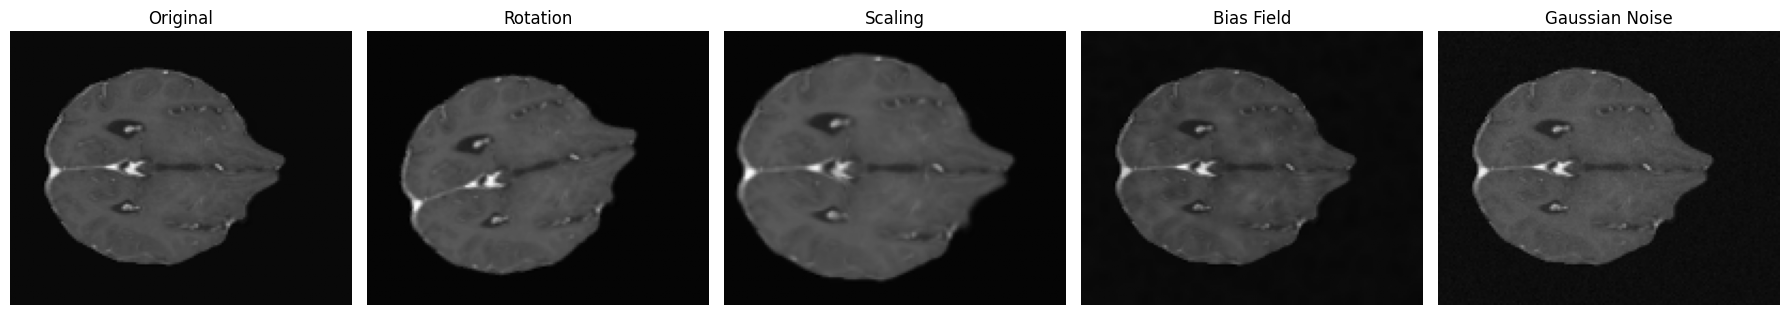

In [18]:
# Escolher o paciente que você quer visualizar
idx = 0  # ou qualquer outro índice
X_original = X_list[idx]  # volume original (128,128,128)
Y_original = Y_list[idx]  # máscara original

# Aplicar as funções de augmentação
X_rot = random_rotation(X_original)
X_scale = random_scaling(X_original)
X_bias = bias_field(X_original)
X_noise = add_gaussian_noise(X_original)

# Visualizar fatias centrais (eixo z = 64)
slice_idx = 64

fig, axes = plt.subplots(1, 5, figsize=(18, 5))
titles = ['Original', 'Rotation', 'Scaling', 'Bias Field', 'Gaussian Noise']
volumes = [X_original, X_rot, X_scale, X_bias, X_noise]

for ax, vol, title in zip(axes, volumes, titles):
    ax.imshow(vol[:, :, slice_idx], cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


## Aplicar em todos os pacientes

In [19]:
X_augmented = []
Y_augmented = []

for i in range(len(X_all)):
    X, Y = X_all[i], Y_all[i]
    print(f"{i+1}/{len(X_all)}")

    # Original
    X_augmented.append(X.astype(np.float32))
    Y_augmented.append(Y.astype(np.float32))

    # Versões aumentadas
    for X_aug, Y_aug in augment_patient(X, Y):
        X_augmented.append(X_aug.astype(np.float32))
        Y_augmented.append(Y_aug.astype(np.float32))

# Converte listas em arrays numpy grandes
X_augmented = np.stack(X_augmented)
Y_augmented = np.stack(Y_augmented)

# Salva tudo em um único arquivo comprimido .npz
np.savez_compressed(SAVE_PATH, X=X_augmented, Y=Y_augmented)
print(f"✅ Dataset aumentado salvo em {SAVE_PATH}")
print(f"Total de amostras salvas: {len(X_augmented)}")

1/38
2/38
3/38
4/38
5/38
6/38
7/38
8/38
9/38
10/38
11/38
12/38
13/38
14/38
15/38
16/38
17/38
18/38
19/38
20/38
21/38
22/38
23/38
24/38
25/38
26/38
27/38
28/38
29/38
30/38
31/38
32/38
33/38
34/38
35/38
36/38
37/38
38/38
✅ Dataset aumentado salvo em dataset_t1c_to_t2w.npz
Total de amostras salvas: 190
